In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# read the file into a list of lines and print to separate files for different outputs
for d in [4,5,6]:
    for version in ["basic", "ensemble", "modelstore"]:
        with open("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/results_"+version+"_"+str(d)+".txt",'r') as f:
            lines = f.read().split("\n")
        output_file_perf = open("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Performance_Output_"+ str(d)+".txt", "w")
        output_file_retrainings = open("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Retrainings_Output_"+ str(d)+".txt", "w")
        output_file_update = open("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Update_Output_"+ str(d)+".txt", "w")


        word_perf = 'Test batch'
        word_drift = 'Change detected'
        word_nondrift = 'No drift but'
        word_update = 'Online model is updated'

        # iterate over lines, and print out line numbers which contain the word of interest.
        for j,line in enumerate(lines):
            if word_perf in line: # or word in line.split() to search for full word
                print("{}".format(line), file=output_file_perf)
            if word_drift in line:
                print("{}".format(line), file=output_file_retrainings)
            if word_update in line:
                print("{}".format(line), file=output_file_update)
            if word_nondrift in line:
                print("{}".format(line), file=output_file_retrainings)


        output_file_perf.close()
        output_file_retrainings.close()
        output_file_update.close()

#Read data from the output files
# Get test scores and batch numbers
results={}
retrainings={}
for d in [4, 5, 6]:  # data streams
    results["AutOL_Data_" + str(d)]={}
    retrainings["AutOL_Data_" + str(d)] = {}
    for version in ["basic", "ensemble", "modelstore"]:
        #Get performance
        read_perf = pd.read_table("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Performance_Output_" + str(d) + ".txt", header=None, sep=' ')
        results["AutOL_Data_" + str(d)][version] = (read_perf.iloc[:, [3, 6]])
        results["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Test score']
        results["AutOL_Data_" + str(d)][version]['Test score'] = results["AutOL_Data_" + str(d)][version]['Test score'].str.rstrip('%').astype('float') / 100.0

        #Get retraining points and types - No : no drift training point, Change: drift training point
        if os.path.getsize("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Retrainings_Output_" + str(d) + ".txt") > 0:
            read_retraining = pd.read_table("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Retrainings_Output_" + str(d) + ".txt", header=None, sep=' ')
            retrainings["AutOL_Data_" + str(d)][version] = read_retraining.iloc[:, [5,0]]
            retrainings["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Type']

        #Get model switch to ensemble/model store or AutOL output
        if version != "basic" and os.path.getsize("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Retrainings_Output_" + str(d) + ".txt") > 0:
            read_update = pd.read_table("/Users/prabhant/OpenML/gama/Results_AutOL/"+version+"/Update_Output_" + str(d) + ".txt", header=None, sep=' ')
            retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]



#Plot-1 Performance

figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

data_names = ["Electricity", "Airlines",  "IMDB", "Vehicle", "SEA - High Abrupt Drift", "HYPERPLANE - High Gradual Drift",
              "SEA - High Mixed Drift"]


#     figs[d].savefig("/Users/prabhant/OpenML/gama/Results_AutOL/Performance_Data"+str(d)+".png")



    #For lines of drift and retraining in second plot

    # if os.path.getsize("/Users/prabhant/OpenML/gama/Results_AutOL/Grace/Retrainings_Output_"+ str(d)+".txt") > 0:
    #     i=0
    #     for xc in retrainings["AutOL_Ensemble_Data_" + str(d)]['Batch number']:
    #         if retrainings["AutOL_Ensemble_Data_" + str(d)]['Type'].iloc[i] == "Change":
    #             ax.axvline(x=xc, linestyle=':', color='b')
    #         else:
    #             ax.axvline(x=xc, linestyle='solid', color='b')
    #         i=i+1
    #
    # if os.path.getsize("/Users/prabhant/OpenML/gama/Results_AutOL/Grace/Retrainings_Output_"+ str(d+1)+".txt") > 0:
    #     i=0
    #     for xc in retrainings["AutOL_Ensemble_Data_" + str(d+1)]['Batch number']:
    #         if retrainings["AutOL_Ensemble_Data_" + str(d+1)]['Type'].iloc[i] == "Change":
    #             ax.axvline(x=xc, linestyle=':', color='r')
    #         else:
    #             ax.axvline(x=xc, linestyle='solid', color='r')
    #         i=i+1

<ipython-input-118-366d8aa43182>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["AutOL_Data_" + str(d)][version]['Test score'] = results["AutOL_Data_" + str(d)][version]['Test score'].str.rstrip('%').astype('float') / 100.0
<ipython-input-118-366d8aa43182>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]


In [119]:
a


{'basic':     Batch number    Type
 0          55001      No
 1         105002      No
 2         155003      No
 3         197132  Change
 4         241273  Change
 5         242352  Change
 6         244164  Change
 7         245213  Change
 8         246347  Change
 9         247387  Change
 10        248984  Change
 11        250163  Change
 12        300164      No
 13        350165      No
 14        400166      No
 15        450167      No,
 'modelstore':    Batch number Type Model update
 0         55001   No    Ensemble.
 1        105002   No    Ensemble.
 2        155003   No    Ensemble.
 3        205004   No    Ensemble.
 4        255005   No    Ensemble.
 5        305006   No    Ensemble.
 6        355007   No    Ensemble.
 7        405008   No    Ensemble.
 8        455009   No    Ensemble.}

<ipython-input-131-5bcff6b87da6>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[d].show()
<ipython-input-131-5bcff6b87da6>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[d].show()


KeyError: 'ensemble'

<Figure size 1800x1440 with 0 Axes>

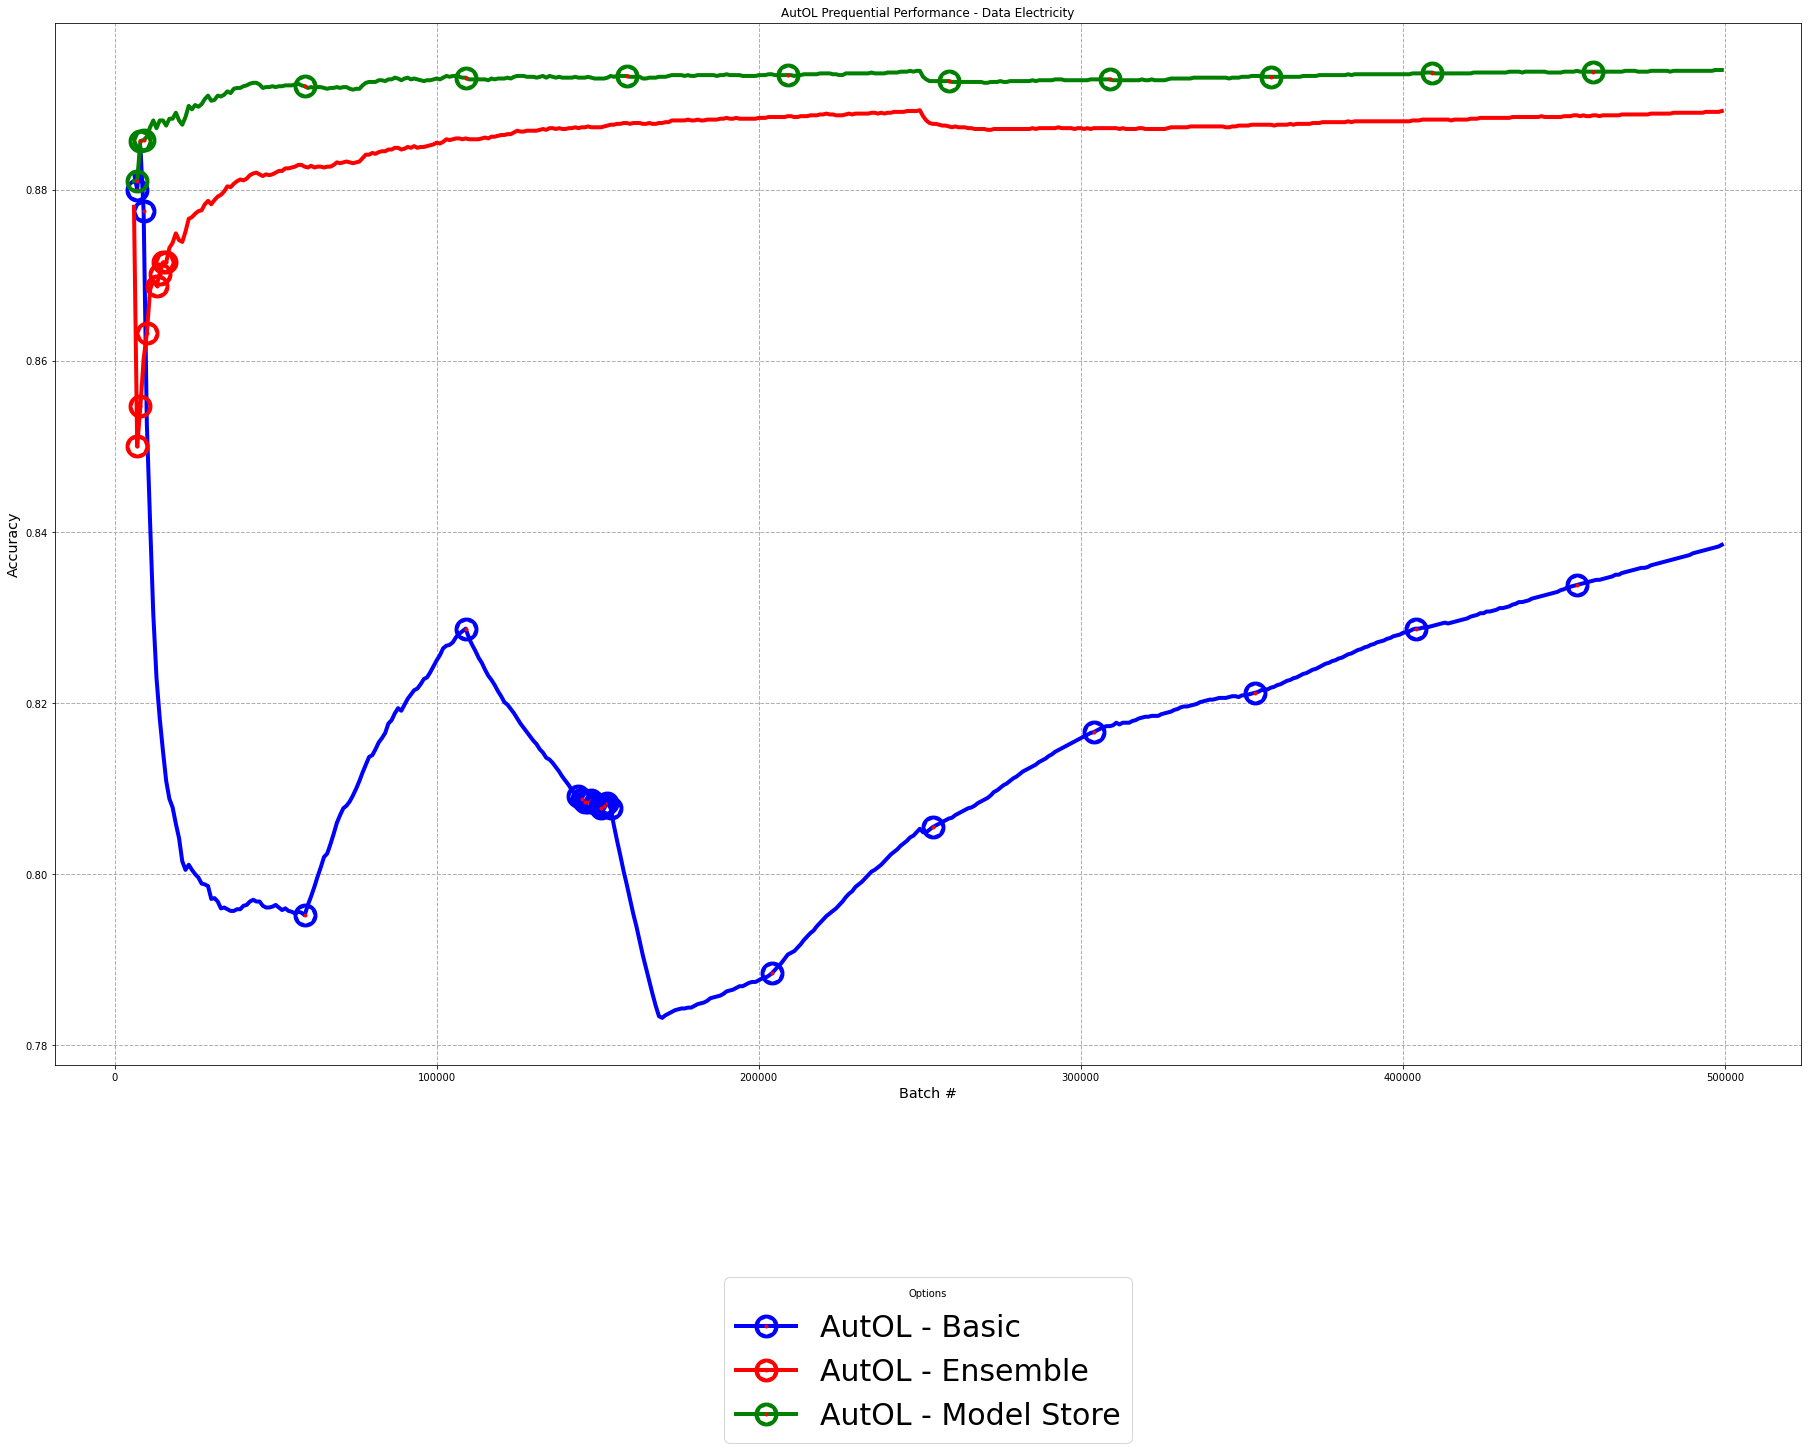

<Figure size 1800x1440 with 0 Axes>

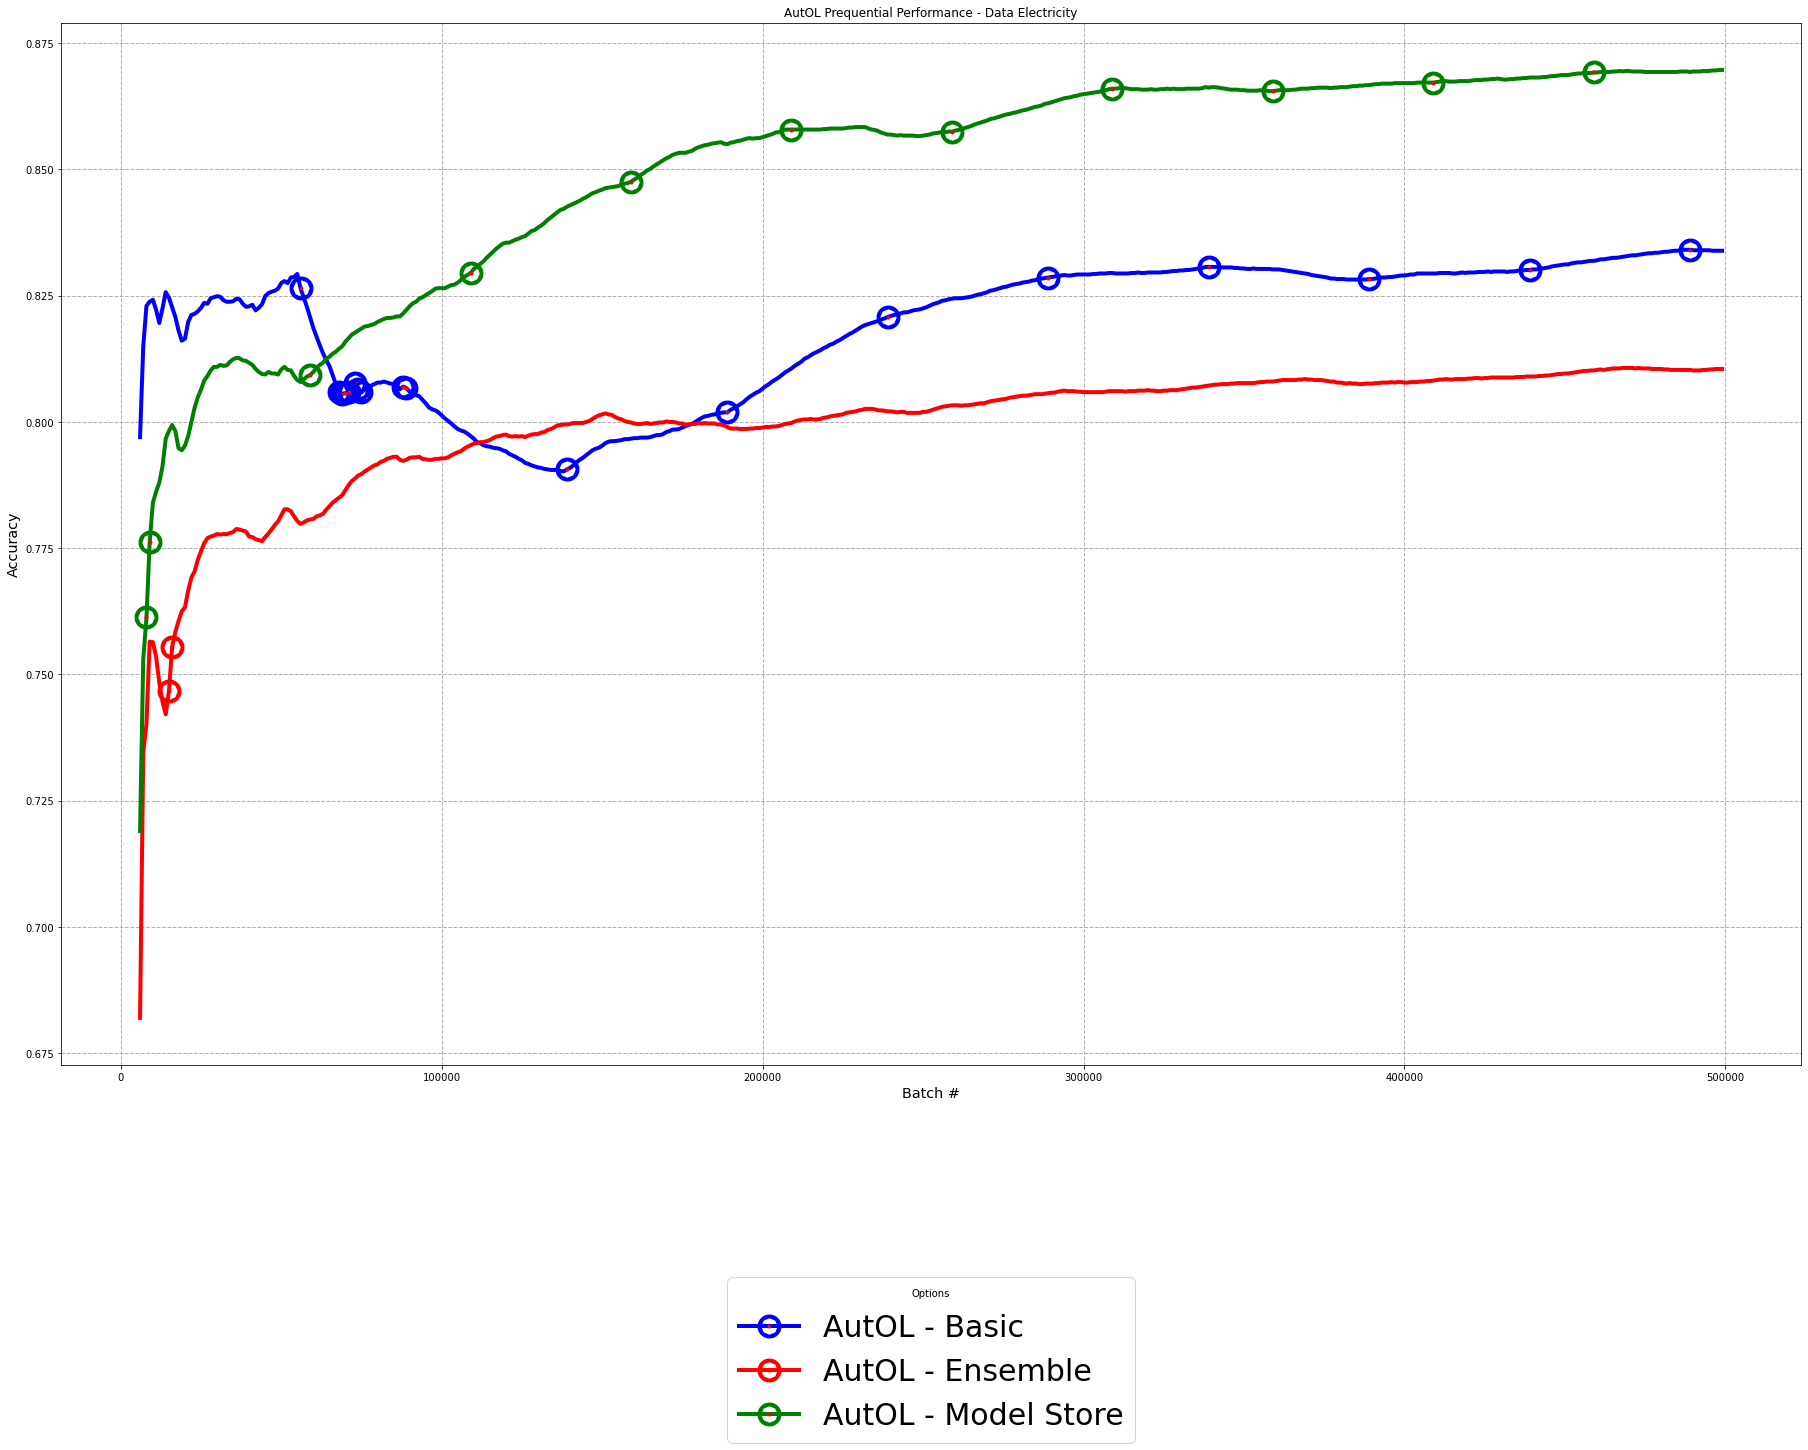

In [131]:
import matplotlib


for d in [4, 5, 6]:
    ### Marker basic
    a = retrainings['AutOL_Data_'+str(d)]
    e = results["AutOL_Data_" + str(d)]['basic']['Batch number']
    markonb = make_marker_array(a,e,'basic')
    markone = make_marker_array(a,e,'ensemble')
    markonm = make_marker_array(a,e,'modelstore')
    ##############################################################
    plt.rcParams["figure.figsize"] = (25, 20)
    plt.rcParams["axes.labelsize"] = ('x-large')
    figs[d] = plt.figure()
    figs[d], ax = plt.subplots(1, 1, sharex='col', sharey='row', constrained_layout=True)

    ax.set(xlabel="Batch #", ylabel="Accuracy")
    ax.grid(linestyle='--', linewidth=1)

    ax.set_title('AutOL Prequential Performance - Data '+data_names[int(d/10)])

    #Plot performance lines of each version
    # basic
    l0 = ax.plot(results["AutOL_Data_" + str(d)]['basic']['Batch number'],
                    results["AutOL_Data_" + str(d)]['basic']['Test score'],
                 'o',markeredgewidth=20 ,markerfacecolor='red',ls='-', ms=4, markevery=markonb,
                    label='AutOL - Basic', lw=4, color='b')
    #ensemble
    l1 = ax.plot(results["AutOL_Data_" + str(d)]['ensemble']['Batch number'],
                    results["AutOL_Data_" + str(d)]['ensemble']['Test score'],
                    'o',markeredgewidth=20 ,markerfacecolor='red',ls='-', ms=4, markevery=markone,
                    label='AutOL - Ensemble', lw=4, color='r')
    #model store
    l2 = ax.plot(results["AutOL_Data_" + str(d)]['modelstore']['Batch number'],
                    results["AutOL_Data_" + str(d)]['modelstore']['Test score'],
                    'o',markeredgewidth=20 ,markerfacecolor='red',ls='-', ms=4, markevery=markonm,
                    label='AutOL - Model Store', lw=4, color='g')


    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.2),
               ncol=1,
               borderaxespad=0.1,
               title="Options",
               prop={'size': 30})
    #plt.yticks(np.arange(results["AutOL_Ensemble_Data_" + str(d)]['Test score'], results["AutOL_Ensemble_Data_" + str(d)]['Test score']+0.1, 0.1))

    plt.plot()
    figs[d].show()

In [91]:
e = results["AutOL_Data_" + str(d)]['basic']['Batch number']
both = set(c).intersection(e)

In [125]:
retrainings['AutOL_Data_'+str(5)]

{'basic':     Batch number    Type
 0          55001      No
 1          67239  Change
 2          68246  Change
 3          69315  Change
 4          70820  Change
 5          72055  Change
 6          73192  Change
 7          74286  Change
 8          87101  Change
 9          88206  Change
 10        138207      No
 11        188208      No
 12        238209      No
 13        288210      No
 14        338211      No
 15        388212      No
 16        438213      No
 17        488214      No,
 'ensemble':    Batch number    Type Model update
 0         14266  Change       AutoML
 1         15926  Change       AutoML,
 'modelstore':     Batch number    Type Model update
 0           7083  Change       AutoML
 1           8537  Change       AutoML
 2          58538      No       AutoML
 3         108539      No       AutoML
 4         158540      No       AutoML
 5         208541      No    Ensemble.
 6         258542      No       AutoML
 7         308543      No       AutoML
 8  

In [68]:
len(results["AutOL_Data_" + str(d)]['basic']['Batch number'])

494

In [81]:
import math
r = []
for j in c:
    i = math.ceil(j/1000)*1000
    r.append(i)
# def roundup(x):
#      return int(math.ceil(x / 100.0)) * 100

In [70]:
results["AutOL_Data_" + str(d)]['basic']['Batch number']

0        6000
1        7000
2        8000
3        9000
4       10000
        ...  
489    495000
490    496000
491    497000
492    498000
493    499000
Name: Batch number, Length: 494, dtype: int64

In [92]:
both = set(r).intersection(e)

In [96]:
markon = [e.index(x) for x in both]


In [94]:
e=list(e)

In [130]:
def make_marker_array(a,e,choice):
    b= a[choice]
    c = list(b['Batch number'])
    r = []
    for j in c:
        i = math.ceil(j/1000)*1000
        r.append(i)
    both = set(r).intersection(e)
    e=list(e)
    markon = [e.index(x) for x in both]
    return markon